/var/folders/tz/tw3ctq595r744r_sx025n5hc0000gn/T/ipykernel_9894/1171781951.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  1 of 1 completed

Iniciando Motor de Riesgo para: CEMEXCPO.MX

Modelo Calibrado. Persistencia (Beta): 0.9501



/var/folders/tz/tw3ctq595r744r_sx025n5hc0000gn/T/ipykernel_9894/1171781951.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nu_params = res.params[-1] # Grados de libertad (t-Student)


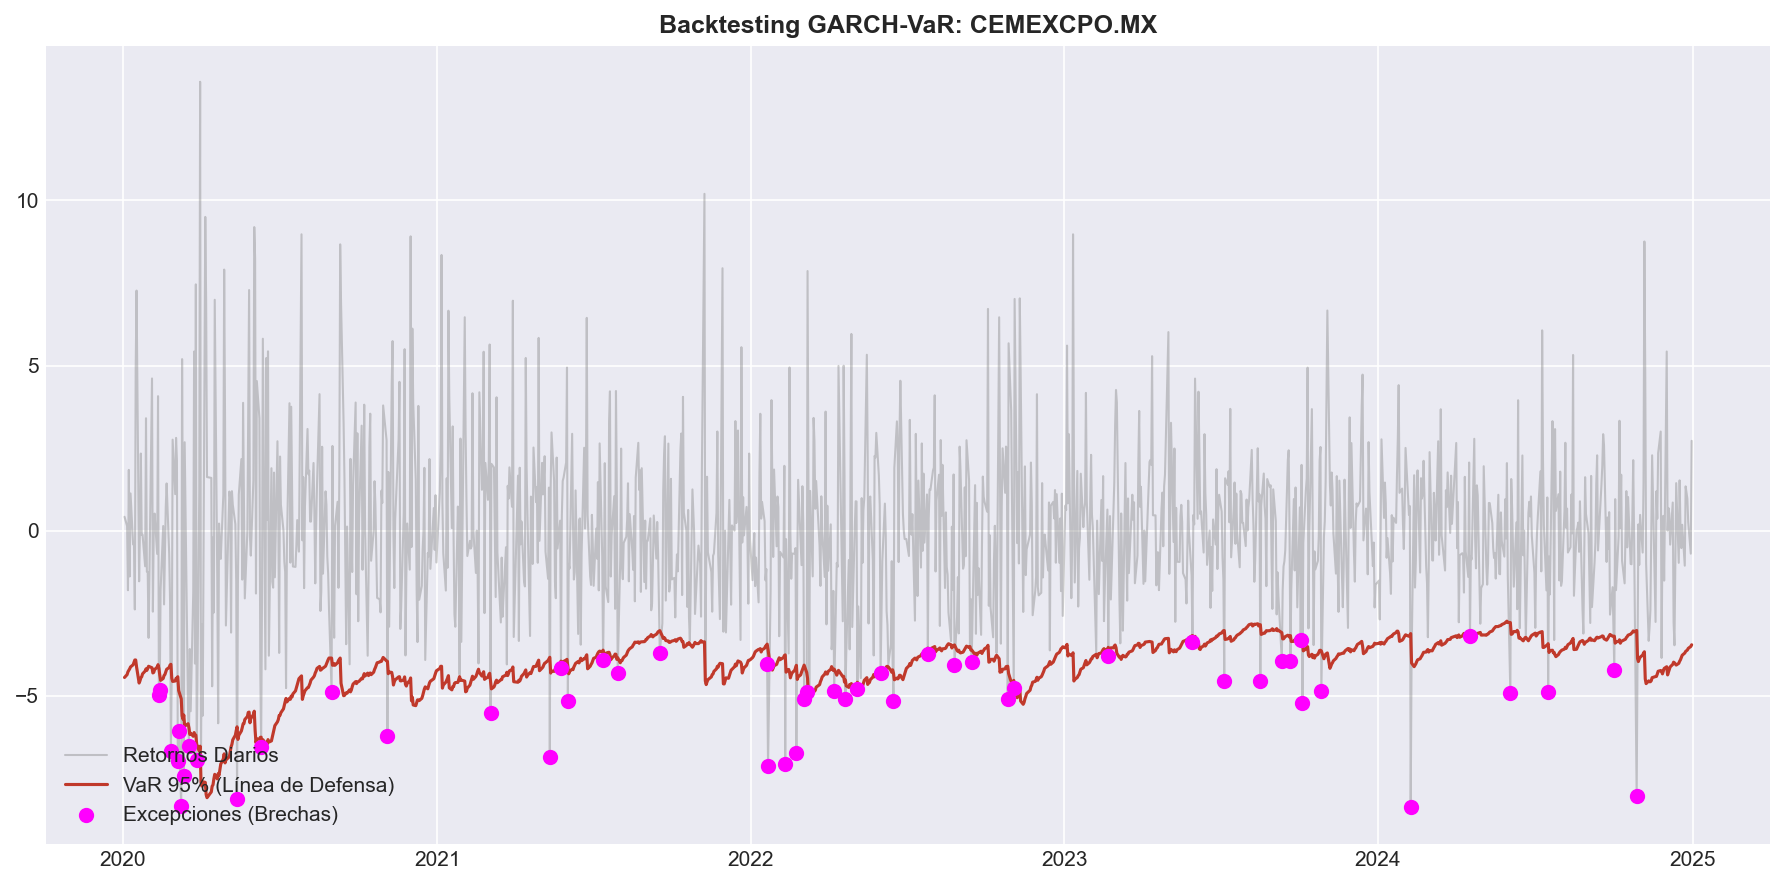


 TASA DE FALLO REAL: 4.05% (Objetivo Teórico: 5.00%)
STATUS: MODELO PERFECTAMENTE CALIBRADO



REPORTE DE RIESGO PARA MAÑANA (2026-01-12)
Activo: CEMEXCPO.MX
Volatilidad Proyectada: 2.22% (Diaria)
Capital en Riesgo (VaR 95%): $34,999.70 MXN
Interprete: Con un 95% de confianza, mañana no perderemos más de esta cantidad.


Expected Shortfall (Promedio de pérdidas extremas): -4.44%


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 150

# ==========================================
# 1. OBTENCIÓN DE DATOS (CEMEX) 🏗️
# ==========================================
ticker = 'CEMEXCPO.MX'
print(f"Iniciando Motor de Riesgo para: {ticker}")

# Descarga y Limpieza
data = yf.download(ticker, start='2020-01-01', end='2025-01-01')['Close']
if isinstance(data, pd.DataFrame):
    data = data.squeeze() # Convertir a Serie si es necesario

# Retornos (x100 para estabilidad del optimizador GARCH)
returns = 100 * data.pct_change().dropna()

# ==========================================
# 2. MODELADO GARCH(1,1) t-Student 🧬
# ==========================================
# Ajustamos el modelo a toda la historia disponible
model = arch_model(returns, vol='Garch', p=1, q=1, mean='Constant', dist='t')
res = model.fit(disp='off')

# Parametros clave
nu_params = res.params[-1] # Grados de libertad (t-Student)
vol_condicional = res.conditional_volatility

print("\nModelo Calibrado. Persistencia (Beta):", f"{res.params['beta[1]']:.4f}")

# ==========================================
# 3. BACKTESTING (Mirando al PASADO) 📸
# ==========================================
# Calculamos el VaR histórico día a día
q_student = model.distribution.ppf(0.05, nu_params)
var_historico = res.params['mu'] + vol_condicional * q_student

# Identificar excepciones (Días donde la pérdida real superó el VaR estimado)
# Alineamos índices para evitar errores
var_series = pd.Series(var_historico, index=returns.index)
excepciones = returns[returns < var_series]

# --- GRÁFICA 1: BACKTESTING ---
fig1, ax = plt.subplots()
ax.plot(returns.index, returns, color='gray', alpha=0.4, label='Retornos Diarios', linewidth=1)
ax.plot(var_series.index, var_series, color='#c0392b', linestyle='-', linewidth=1.5, label='VaR 95% (Línea de Defensa)')
ax.scatter(excepciones.index, excepciones.values, color='magenta', s=40, zorder=5, label='Excepciones (Brechas)')
ax.set_title(f'Backtesting GARCH-VaR: {ticker}', fontsize=12, fontweight='bold')
ax.legend(loc='lower left')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# Validación Numérica (Kupiec)
n_fallos = len(excepciones)
pct_fallos = n_fallos / len(returns)
print(f"\n TASA DE FALLO REAL: {pct_fallos:.2%} (Objetivo Teórico: 5.00%)")
if 0.04 <= pct_fallos <= 0.06:
    print("STATUS: MODELO PERFECTAMENTE CALIBRADO")
else:
    print("STATUS: EL MODELO NECESITA AJUSTES")

# ==========================================
# 4. DIAGNÓSTICO (Validación Matemática) 🧪
# ==========================================
# --- GRÁFICA 2: DIAGNÓSTICO ---
std_resid = res.resid / vol_condicional
fig2 = plt.figure(figsize=(10, 8), dpi = 1500)

# QQ-Plot
ax1 = fig2.add_subplot(211)
sm.qqplot(std_resid, line='s', ax=ax1, markersize=3)
ax1.set_title('QQ-Plot: ¿Capturamos bien las colas pesadas?', fontsize=10)

# ACF
ax2 = fig2.add_subplot(212)
plot_acf(std_resid**2, lags=40, ax=ax2, alpha=0.05, title='ACF Residuos²: ¿Queda volatilidad sin explicar?')
plt.tight_layout()
plt.show()

# ==========================================
# 5. PRONÓSTICO
# ==========================================
# Predecimos la volatilidad para el día siguiente (T+1)
forecast = res.forecast(horizon=1)
vol_mañana = np.sqrt(forecast.variance.values[-1, :])[0]

# Calculamos VaR y ES en dinero para mañana
capital = 1000000 # 1 Millón de pesos
var_pct_mañana = res.params['mu'] + vol_mañana * q_student
var_cash = (var_pct_mañana / 100) * capital

print("\n" + "="*40)
print(f"REPORTE DE RIESGO PARA MAÑANA ({pd.Timestamp.now().date()})")
print("="*40)
print(f"Activo: {ticker}")
print(f"Volatilidad Proyectada: {vol_mañana:.2f}% (Diaria)")
print(f"Capital en Riesgo (VaR 95%): ${abs(var_cash):,.2f} MXN")
print("Interprete: Con un 95% de confianza, mañana no perderemos más de esta cantidad.")

# ==========================================
# 6. VISUALIZACIÓN DE LA DISTRIBUCIÓN (FHS)
# ==========================================

# A. Bootstrap: Simulamos 10,000 escenarios posibles para mañana
# Tomamos los residuos históricos (el "ruido" limpio) y le inyectamos la volatilidad de mañana
simulaciones = 10000
residuos_simulados = np.random.choice(std_resid, simulaciones, replace=True)
retornos_simulados = residuos_simulados * vol_mañana # Retorno = Ruido * Volatilidad

# B. Calculamos métricas sobre la simulación
VaR_95_sim = np.percentile(retornos_simulados, 5) # Percentil 5
ES_95_sim = retornos_simulados[retornos_simulados <= VaR_95_sim].mean() # Promedio de la cola

# C. Gráfico de Distribución
plt.figure(figsize=(10, 6), dpi = 1500)

# Histograma (La montaña de probabilidades)
sns.histplot(retornos_simulados, bins=100, kde=True, color='#2c3e50', stat='density', alpha=0.6, label='Escenarios Simulados')

# Línea de VaR (El límite)
plt.axvline(VaR_95_sim, color='#e74c3c', linestyle='--', linewidth=2.5, label=f'VaR 95%: {VaR_95_sim:.2f}%')

# Línea de Expected Shortfall (El desastre promedio)
plt.axvline(ES_95_sim, color='#f1c40f', linestyle='-', linewidth=2.5, label=f'Expected Shortfall: {ES_95_sim:.2f}%')

# Zona de Peligro (Sombreado)
plt.axvspan(min(retornos_simulados), VaR_95_sim, alpha=0.15, color='red')

plt.title(f'Distribución de Riesgo Proyectado para MAÑANA (CEMEX)', fontsize=14, fontweight='bold')
plt.xlabel('Retorno Diario Potencial (%)')
plt.ylabel('Probabilidad (Densidad)')
plt.legend(loc='upper left')
plt.xlim(-10, 10)
plt.grid(True, alpha=0.3)

plt.show()

print(f"Expected Shortfall (Promedio de pérdidas extremas): {ES_95_sim:.2f}%")